In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr

In [2]:

data, source = dr.read('kospi_extended.csv')

Loading data from file /home/changhyun/workspace/cxk858/dataset/kospi_extended.csv...



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2461
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2456 non-null   object 
 1   Open                 2456 non-null   float64
 2   High                 2456 non-null   float64
 3   Low                  2456 non-null   float64
 4   Close                2456 non-null   float64
 5   Adj Close            2456 non-null   float64
 6   Volume               2456 non-null   float64
 7   Daily_trading_range  2456 non-null   float64
 8   Log_Volume_change    2455 non-null   float64
 9   Daily_return         2455 non-null   float64
 10  Daily_log_return     2455 non-null   float64
 11  Target               2434 non-null   float64
dtypes: float64(11), object(1)
memory usage: 249.4+ KB


In [4]:
from arch import arch_model

In [5]:
trainingData = data[22:]

In [6]:
data = data.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily_return'], axis=1)
trainingData = trainingData.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily_return'], axis=1)

In [7]:
trainingData.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 22 to 2461
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2434 non-null   float64
 1   Log_Volume_change    2434 non-null   float64
 2   Daily_log_return     2434 non-null   float64
 3   Target               2434 non-null   float64
dtypes: float64(4)
memory usage: 95.1 KB


,Daily_trading_range,Log_Volume_change,Daily_log_return,Target
2457,52.800049,-11.725771,0.951682,0.146351
2458,49.559814,-8.405652,1.690097,0.146712
2459,35.030029,-2.425135,0.061971,0.141543
2460,31.379882,3.955703,0.423155,0.141185
2461,68.859863,2.565210,1.860263,0.147144


In [8]:
log_return = data[['Daily_log_return']]
log_return = log_return.dropna()
gm = arch_model(log_return, p=1,q=1)

In [9]:
gm_res = gm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 251495.80252456426
Iteration:      2,   Func. Count:     15,   Neg. LLF: 135453701121.83444
Iteration:      3,   Func. Count:     23,   Neg. LLF: 4184.8189301661605
Iteration:      4,   Func. Count:     30,   Neg. LLF: 644685848.9824195
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3199.1556810582883
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3189.9345572244792
Iteration:      7,   Func. Count:     47,   Neg. LLF: 3189.933484749543
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3189.933441365098
Iteration:      9,   Func. Count:     56,   Neg. LLF: 3189.933441365245
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3189.933441365098
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


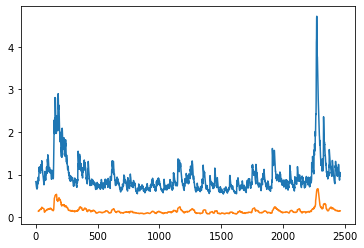

In [10]:
plt.plot(gm_res.conditional_volatility)
plt.plot(data[['Target']])
plt.show()

In [11]:
pred = {}
print(len(log_return))

2455


In [12]:
window = 22
for i in range(window, len(log_return)+1):
    res = gm.fit(last_obs=i, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i-1]
    pred[fcast.name] = fcast

In [13]:
e_pred={}

In [14]:
egm = arch_model(log_return, p=1,q=1,o=1)
for i in range(window, len(log_return)+1):
    e_res = egm.fit(last_obs=i, disp='off')
    temp = e_res.forecast(horizon=1).variance
    fcast = temp.iloc[i-1]
    e_pred[fcast.name] = fcast

/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [15]:
print(pd.DataFrame(e_pred).T)
print(pd.DataFrame(pred).T)

           h.1
22    0.755532
23    0.731494
24    0.778273
25    0.961922
26    1.342780
...        ...
2457  0.799416
2458  0.766969
2459  0.717669
2460  0.674841
2461  0.659454

[2434 rows x 1 columns]
           h.1
22    0.755468
23    0.731483
24    0.778261
25    0.936984
26    1.009078
...        ...
2457  0.935185
2458  1.105744
2459  0.999141
2460  0.919742
2461  1.146614

[2434 rows x 1 columns]


In [16]:
trainingData['GARCH'] = pd.DataFrame(pred).T
trainingData['GJR'] = pd.DataFrame(e_pred).T
trainingData

,Daily_trading_range,Log_Volume_change,Daily_log_return,Target,GARCH,GJR
22,26.100098,-1.699365,0.467526,0.139579,0.755468,0.755532
23,25.719971,4.913988,-0.580043,0.140232,0.731483,0.731494
24,39.820068,10.396094,-1.172230,0.144005,0.778261,0.778273
25,34.569946,-7.281598,-1.829317,0.142697,0.936984,0.961922
26,45.950073,2.392077,-1.571156,0.148160,1.009078,1.342780
...,...,...,...,...,...,...
2457,52.800049,-11.725771,0.951682,0.146351,0.935185,0.799416
2458,49.559814,-8.405652,1.690097,0.146712,1.105744,0.766969
2459,35.030029,-2.425135,0.061971,0.141543,0.999141,0.717669
2460,31.379882,3.955703,0.423155,0.141185,0.919742,0.674841


In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow import keras

In [18]:
y_values = trainingData[['Target']]
x_values = trainingData.drop(['Target'], axis=1)

In [19]:
x_values.info()
y_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 22 to 2461
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2434 non-null   float64
 1   Log_Volume_change    2434 non-null   float64
 2   Daily_log_return     2434 non-null   float64
 3   GARCH                2434 non-null   float64
 4   GJR                  2434 non-null   float64
dtypes: float64(5)
memory usage: 114.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 22 to 2461
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2434 non-null   float64
dtypes: float64(1)
memory usage: 38.0 KB


In [20]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_values)
scaled_y = scaler.fit_transform(y_values)

In [21]:
split = int(len(trainingData)*0.8)

In [22]:
window = 22
trainX = scaled_x[:split]
testX = scaled_x[split:]
trainY = scaled_y[:split]
testY = scaled_y[split:]

In [23]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window+1, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
for i in range(window, len(testX)):
    Xtest.append(testX[i-window:i, :testX.shape[1]])
    ytest.append(testY[i])

In [24]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [25]:
print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1924, 22, 5)
(1924, 1)
-----
(465, 22, 5)
(465, 1)


In [37]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, ytrain, batch_size=16, epochs=20, validation_split=0.2, shuffle=False)

Epoch 1/20
97/97 [==============================] - 6s 23ms/step - loss: 0.0263 - val_loss: 0.0060

In [38]:
forecast = model.predict(Xtest)

In [39]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

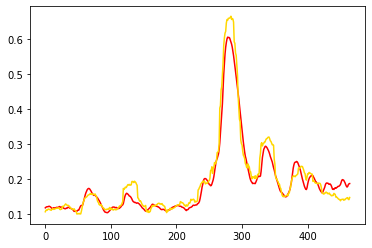

In [40]:
plt.plot(rev_forecast, color='red')
plt.plot(rev_ytest, color='gold')
plt.savefig("images/multi_layer_hybrid_pred.png")

plt.show()

In [41]:
testScore = mean_squared_error(rev_ytest, rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(rev_ytest, rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.0007530731925692829 MSE
test Score: 0.027442179078369176 RMSE
test Score: 0.09350020285608329 MAPE
